In [30]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [ ]:
Step -1 Pre-processing for customer data to create a phrase 
1) manufacturing labour at XYZ corporation, construction sector
2) if designation not present then employee at XYZ corporation, construction sector
3) many more variations are to be formed

Step -2 Pre-processing for watch-list

1) noisy data removal like to be determined,dates , months , sanctioned entity, EXIT DUE TO ML CONCERN ,NO ACCOUNT TO BE OPENED
2) extraction of only biography portion , and if not then only 3 sentences

Step-3 Generating cls pooled embeddings using BERT 

Step-4 Utilized supervised approach two approaches
1) obtaining cosine similarity , obtaining best threshold using plot of threshold v/s F1 score. But results were not so much good.
Results were F1 score achieved was 0.45 with F1 score of 0.71.
2) second approach is to use supervised model i.e. ANN or 
BERTforsequence classification (time consumption for running one epoch using dataset and dataloaders was more than 24 hours. ) and 
the model obtained from checkpoint was also not performing good.Used
Hence discarded that, now used ANN 





In [31]:
pip install tensorflow

In [32]:
pip install keras_tuner

In [33]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import gensim.downloader as api
from sklearn.metrics import f1_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import Dot,Reshape,Flatten
from tensorflow.keras.layers import Dense
from keras import backend as K
from tensorflow.keras.layers import Dense,Dropout,Activation,Embedding,Conv1D
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow.keras.backend as K
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import keras_tuner as kt
from keras.models import Sequential,Model
from keras.layers import Dropout
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters
from itertools import product
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,f1_score
from tensorflow.keras import regularizers

In [34]:
df=pd.read_excel("final_data_for_occupation_final.xlsx")

In [35]:
df.isnull().sum()

Unnamed: 0             0
V_OCC_DESC             5
V_OCC_SEC_DESC         5
V_EMPLOYER_NAME_x    432
V_BIOGRAPHY            0
LABEL                  0
dtype: int64

In [36]:
df.head()

,Unnamed: 0,V_OCC_DESC,V_OCC_SEC_DESC,V_EMPLOYER_NAME_x,V_BIOGRAPHY,LABEL
0,0,MANUFACTURING LABOURERS,MANUFACTURING,BEYONICS PRECISION (M) SDN BHD,[BIOGRAPHY] To be determined. [IDENTIFICATION]...,0
1,1,MANUFACTURING LABOURERS,MANUFACTURING,BEYONICS PRECISION (M) SDN BHD,[BIOGRAPHY] To be determined. [IDENTIFICATION]...,0
2,2,ENGINEERING PROFESSIONALS (INCLUDING ELECTROTE...,CONSTRUCTION,SRI ESBINA (M) SDN BHD,[BIOGRAPHY] Military Attaché to Netherlands (J...,0
3,3,MANUFACTURING LABOURERS,GAMBLING/BETTING ACTIVITIES/JUNKET /CASINO/GAM...,GENTING MALAYSIA BERHAD,[BIOGRAPHY] General Manager of Guizhou Provinc...,0
4,4,MANUFACTURING LABOURERS,GAMBLING/BETTING ACTIVITIES/JUNKET /CASINO/GAM...,GENTING MALAYSIA BERHAD,[BIOGRAPHY] Member of the Board of Directors o...,0


In [37]:
df.shape

(15797, 6)

In [38]:
df=df.sample(frac=1)

# PRE-PROCESSING STEPS

In [39]:
df[(df["V_OCC_DESC"].isnull()) & (df["V_OCC_SEC_DESC"].isnull()) & (df["V_EMPLOYER_NAME_x"].isnull())]

,Unnamed: 0,V_OCC_DESC,V_OCC_SEC_DESC,V_EMPLOYER_NAME_x,V_BIOGRAPHY,LABEL
15679,12903,NaN,NaN,NaN,[BIOGRAPHY] Member of the Jiangxi Provincial P...,1
15680,12904,NaN,NaN,NaN,[BIOGRAPHY] Member of the Jiangxi Provincial P...,1


In [40]:
df.drop(df[(df["V_OCC_DESC"].isnull()) & (df["V_OCC_SEC_DESC"].isnull()) & (df["V_EMPLOYER_NAME_x"].isnull())].index,axis=0,inplace=True)

In [41]:
df.reset_index(inplace=True)

In [42]:
df["CUSTOMER_BIOGRAPHY"]=["" for i in df.index]

In [43]:
df["CUSTOMER_BIOGRAPHY"].shape

(15795,)

In [1]:
df.isnull().sum()

NameError: name 'df' is not defined

In [44]:
# if all three available
key=0
j=[]
for i in df.index:

    s=""
    if np.any(df.loc[i,["V_OCC_DESC"]].notnull()):
        s=df.loc[i,"V_OCC_DESC"]
#         print(s)
    if np.any(df.loc[i,["V_EMPLOYER_NAME_x"]].notnull()):
        if s!="":
            s=s+" "+"at"+" "+df.loc[i,'V_EMPLOYER_NAME_x']
            key=1 # employer & occ present
        else:
            s="employee "+"at"+" "+df.loc[i,'V_EMPLOYER_NAME_x']
            key=2 # employer & occ not present
    else:
         if s!="":
                key=3 # occ present but no employer but occ present
        
    if np.any(df.loc[i,["V_OCC_SEC_DESC"]].notnull()):
        if s=="": # no employer no occ present , dept present
            s=df.loc[i,"V_OCC_SEC_DESC"]+" sector"
        elif key==1 or key==2 or key==3:# occ may/may not be present but employer  present, key==3 occ present but employer not present
            s=s+", "+df.loc[i,"V_OCC_SEC_DESC"]+" sector"
     
    else:# no dept desc
        pass
            
    j.append(s) 


In [45]:
df["CUSTOMER_BIOGRAPHY"]=j
df['CUSTOMER_BIOGRAPHY']=df['CUSTOMER_BIOGRAPHY'].str.upper()


In [46]:
df['V_OCC_DESC']=df['V_OCC_DESC'].apply(lambda x: "" if pd.isna(x) else x)
df['V_EMPLOYER_NAME_x']=df['V_EMPLOYER_NAME_x'].apply(lambda x: "" if pd.isna(x) else x)
df["V_OCC_SEC_DESC"]=df["V_OCC_SEC_DESC"].apply(lambda x: "" if pd.isna(x) else x)


In [47]:
df

,index,Unnamed: 0,V_OCC_DESC,V_OCC_SEC_DESC,V_EMPLOYER_NAME_x,V_BIOGRAPHY,LABEL,CUSTOMER_BIOGRAPHY
0,14126,14126,MANUFACTURING LABOURERS,MANUFACTURING,IMPERIAL GARMENTS SDN BHD,[AUSTRALIA SANCTIONS - DFAT-AS] No 1498 (Oct 2...,0,MANUFACTURING LABOURERS AT IMPERIAL GARMENTS S...
1,4451,4451,PRODUCTION AND MANUFACTURING MANAGERS,"OTHER MANUFACTURING, EXCEPT ARMS AND WEAPONRY",CRRC ROLLING STOCK CENTRE,[BIOGRAPHY] Chairman of Sichuan Development Of...,0,PRODUCTION AND MANUFACTURING MANAGERS AT CRRC ...
2,8890,8890,SHOP SALES ASSISTANTS,OTHER WHOLESALE AND RETAIL TRADE ACTIVITIES N.E.C,TF VALUE MART SDN BHD,[BIOGRAPHY] Member of Pyithu Hluttaw represent...,0,SHOP SALES ASSISTANTS AT TF VALUE MART SDN BHD...
3,15395,15395,"AGRICULTURAL, FORESTRY, FARMING AND FISHERY LA...","AGRICULTURE, FORESTRY AND FISHING",HUAT LAI BROILER BREEDERS SDN BHD,[BIOGRAPHY] Joint Secretary (Director) of Bang...,0,"AGRICULTURAL, FORESTRY, FARMING AND FISHERY LA..."
4,12697,12697,"AGRICULTURAL, FORESTRY, FARMING AND FISHERY LA...","AGRICULTURE (CROPS & ANIMAL PRODUCTION), AQUAC...",FELCRA BERHAD,[BIOGRAPHY] Deputy Secretary (Deputy Commissio...,0,"AGRICULTURAL, FORESTRY, FARMING AND FISHERY LA..."
...,...,...,...,...,...,...,...,...
15790,10524,10524,MANUFACTURING LABOURERS,"AGRICULTURE, FORESTRY AND FISHING",LADANG KEKAYAAN,[BIOGRAPHY] Deputy Secretary of Bangladesh (re...,0,"MANUFACTURING LABOURERS AT LADANG KEKAYAAN, AG..."
15791,4472,4472,ADMINISTRATIVE ASSOCIATE PROFESSIONALS,PUBLIC ADMINISTRATION AND DEFENCE; COMPULSORY ...,HIGH COMMISSION OF INDIA,[BIOGRAPHY] Senior general manager of MECON Li...,0,ADMINISTRATIVE ASSOCIATE PROFESSIONALS AT HIGH...
15792,11986,11986,MANUFACTURING LABOURERS,MANUFACTURING,NSK MICRO PRECISION (M) SDN BHD,[BIOGRAPHY] Member of Sagaing Region Hluttaw r...,0,MANUFACTURING LABOURERS AT NSK MICRO PRECISION...
15793,5147,5147,FINANCIAL ANALYSTS,"OTHER PROFESSIONAL, SCIENTIFIC AND TECHNICAL A...",HUAWEI TECHNOLOGIES (M) SDN BHD,CNCCDI;[BIOGRAPHY] President of Civil Affairs ...,0,FINANCIAL ANALYSTS AT HUAWEI TECHNOLOGIES (M) ...


# WATCHLIST PRE-PROCESSING

In [48]:
import calendar
cal=list(calendar.month_name)
for i in list(calendar.month_name[1:]):
    cal.append(i[:3])


In [49]:
cal_re="(%s)" % "|".join(cal)[1:]
cal_re


'(January|February|March|April|May|June|July|August|September|October|November|December|Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)'

In [50]:
import re
# biography examination
patt=re.compile("\(sanctioned entity\)|\(reported "+cal_re+" \d{4} (-*) \)(\.{0,1})|"+"\(\s*"+cal_re+" \d{4} (-*) "+cal_re+" \d{4}\s*\)|\(Associated to sanctioned entity (-*) reported \d{4}(\s*\.*)\)|\(\s*-\s*"+cal_re+"\s*\d{4}\)\s*\(\s*-\s*"+cal_re+"\s*\d{4}\s*\)|To be determined(\s*\.*)|",re.IGNORECASE)
patt2=re.compile("REQUIRES ECDD & SENIOR MGMT APPROVAL|PNG Mule Accounts (WCL)|EXIT DUE TO ML CONCERN|NO ACCOUNT TO BE OPENED|AMLA FREEZING ORDER|AMLA FORFEITURE|CLOSE ACC AS ADVISED BY AG|Exit due to ML/TF concern|NO ACCOUNT TO BE OPENED \(OU\)",re.IGNORECASE)
print(re.sub(patt,"","(reported Aug 2019 - )"))
print(re.sub(patt,"","(reported Aug 2019 - )."))
print(re.sub(patt,"","(Aug 2020 - Oct 2022)"))
print(re.sub(patt,"","( - Jun 2018) ( - Jun 2018)"))
print(re.sub(patt,"","To be determined"))


In [51]:
df['V_BIOGRAPHY']=df['V_BIOGRAPHY'].str.upper()

In [52]:
df['WATCHLIST_BIOGRAPHY'] = df['V_BIOGRAPHY'].copy()
df["WATCHLIST_BIOGRAPHY"]=df["WATCHLIST_BIOGRAPHY"].apply(lambda x: re.sub(patt,"",x))
df["WATCHLIST_BIOGRAPHY"]=df["WATCHLIST_BIOGRAPHY"].apply(lambda x: re.sub(patt2,"",x))


In [53]:
# df['WATCHLIST_BIOGRAPHY'] = df['V_BIOGRAPHY'].str.extract(r'\[BIOGRAPHY\](.*?)\[IDENTIFICATION\]')  
ind1=df[df['WATCHLIST_BIOGRAPHY'].apply(lambda x: len(re.findall('\[BIOGRAPHY\](.*?)\[IDENTIFICATION\]',x))>0)].index
ind2=df[df['WATCHLIST_BIOGRAPHY'].apply(lambda x: len(re.findall('\[BIOGRAPHY\](.*?)\[IDENTIFICATION\]',x))==0)].index


In [54]:
# truncation for biographies containing biography secion
df.loc[ind1.to_list(),"WATCHLIST_BIOGRAPHY"]=df.loc[ind1.to_list(),"WATCHLIST_BIOGRAPHY"].str.extract(r'\[BIOGRAPHY\](.*?)\[IDENTIFICATION\]').values.flatten()


In [55]:
# Truncation for biographies where no biography secion is present  - 

df.loc[ind2.to_list(),"WATCHLIST_BIOGRAPHY"]=df.loc[ind2.to_list(),"WATCHLIST_BIOGRAPHY"].apply(lambda x:".".join(re.split("\.",x)[:3]))


In [56]:
df['WATCHLIST_BIOGRAPHY']=df['WATCHLIST_BIOGRAPHY'].apply(lambda x: "" if pd.isna(x) else x)
df['WATCHLIST_BIOGRAPHY']=df['WATCHLIST_BIOGRAPHY'].apply(lambda x: re.sub("^\s*","",x))
df=df[df["WATCHLIST_BIOGRAPHY"].apply(lambda x: x!="")]


In [57]:
df.reset_index(inplace=True)

In [58]:
df

,level_0,index,Unnamed: 0,V_OCC_DESC,V_OCC_SEC_DESC,V_EMPLOYER_NAME_x,V_BIOGRAPHY,LABEL,CUSTOMER_BIOGRAPHY,WATCHLIST_BIOGRAPHY
0,0,14126,14126,MANUFACTURING LABOURERS,MANUFACTURING,IMPERIAL GARMENTS SDN BHD,[AUSTRALIA SANCTIONS - DFAT-AS] NO 1498 (OCT 2...,0,MANUFACTURING LABOURERS AT IMPERIAL GARMENTS S...,OWNER OF QUEEN STAR COMPUTER COMPANY PARTNER ...
1,1,4451,4451,PRODUCTION AND MANUFACTURING MANAGERS,"OTHER MANUFACTURING, EXCEPT ARMS AND WEAPONRY",CRRC ROLLING STOCK CENTRE,[BIOGRAPHY] CHAIRMAN OF SICHUAN DEVELOPMENT OF...,0,PRODUCTION AND MANUFACTURING MANAGERS AT CRRC ...,CHAIRMAN OF SICHUAN DEVELOPMENT OF ASSET MANAG...
2,2,8890,8890,SHOP SALES ASSISTANTS,OTHER WHOLESALE AND RETAIL TRADE ACTIVITIES N.E.C,TF VALUE MART SDN BHD,[BIOGRAPHY] MEMBER OF PYITHU HLUTTAW REPRESENT...,0,SHOP SALES ASSISTANTS AT TF VALUE MART SDN BHD...,MEMBER OF PYITHU HLUTTAW REPRESENTING DEFENCE ...
3,3,15395,15395,"AGRICULTURAL, FORESTRY, FARMING AND FISHERY LA...","AGRICULTURE, FORESTRY AND FISHING",HUAT LAI BROILER BREEDERS SDN BHD,[BIOGRAPHY] JOINT SECRETARY (DIRECTOR) OF BANG...,0,"AGRICULTURAL, FORESTRY, FARMING AND FISHERY LA...",JOINT SECRETARY (DIRECTOR) OF BANGLADESH INSTI...
4,4,12697,12697,"AGRICULTURAL, FORESTRY, FARMING AND FISHERY LA...","AGRICULTURE (CROPS & ANIMAL PRODUCTION), AQUAC...",FELCRA BERHAD,[BIOGRAPHY] DEPUTY SECRETARY (DEPUTY COMMISSIO...,0,"AGRICULTURAL, FORESTRY, FARMING AND FISHERY LA...",DEPUTY SECRETARY (DEPUTY COMMISSIONER) TO THE ...
...,...,...,...,...,...,...,...,...,...,...
15534,15790,10524,10524,MANUFACTURING LABOURERS,"AGRICULTURE, FORESTRY AND FISHING",LADANG KEKAYAAN,[BIOGRAPHY] DEPUTY SECRETARY OF BANGLADESH (RE...,0,"MANUFACTURING LABOURERS AT LADANG KEKAYAAN, AG...",DEPUTY SECRETARY OF BANGLADESH DIRECTOR OF TO...
15535,15791,4472,4472,ADMINISTRATIVE ASSOCIATE PROFESSIONALS,PUBLIC ADMINISTRATION AND DEFENCE; COMPULSORY ...,HIGH COMMISSION OF INDIA,[BIOGRAPHY] SENIOR GENERAL MANAGER OF MECON LI...,0,ADMINISTRATIVE ASSOCIATE PROFESSIONALS AT HIGH...,SENIOR GENERAL MANAGER OF MECON LIMITED (REPOR...
15536,15792,11986,11986,MANUFACTURING LABOURERS,MANUFACTURING,NSK MICRO PRECISION (M) SDN BHD,[BIOGRAPHY] MEMBER OF SAGAING REGION HLUTTAW R...,0,MANUFACTURING LABOURERS AT NSK MICRO PRECISION...,MEMBER OF SAGAING REGION HLUTTAW REPRESENTING ...
15537,15793,5147,5147,FINANCIAL ANALYSTS,"OTHER PROFESSIONAL, SCIENTIFIC AND TECHNICAL A...",HUAWEI TECHNOLOGIES (M) SDN BHD,CNCCDI;[BIOGRAPHY] PRESIDENT OF CIVIL AFFAIRS ...,0,FINANCIAL ANALYSTS AT HUAWEI TECHNOLOGIES (M) ...,PRESIDENT OF CIVIL AFFAIRS NO.2 COURT MINQIN C...


In [59]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [60]:
# Function to process a single pair of sentences and return the CLS token embedding
def process_pair(sentence1, sentence2):
    # Tokenize sentences and add special tokens
    tokens = tokenizer(sentence1, sentence2, return_tensors='pt', padding=True, truncation=True)
    
    # Pass tokenized input to BERT model to obtain CLS token embeddings
    with torch.no_grad():
        outputs = model(**tokens)
    
    # Extract CLS token embeddings
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    
    return cls_embedding


In [61]:
embeddings = []
for _, row in df.iterrows():
    sentence1 = row['CUSTOMER_BIOGRAPHY']
    sentence2 = row['WATCHLIST_BIOGRAPHY']
    cls_embedding = process_pair(sentence1, sentence2)
    embeddings.append(cls_embedding)

# Stack the embeddings into a single tensor
embeddings_tensor = torch.stack(embeddings)

# Add a new column to the DataFrame to store the embeddings
df['Embeddings'] = embeddings_tensor.tolist()  # Convert tensor to list for DataFrame compatibility

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
C:\Users\80009028\AppData\Local\Temp\1\ipykernel_639088\603872570.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [62]:
df1=df[['Embeddings','LABEL']]

In [63]:
x = np.array(df1['Embeddings'].tolist())
y=df1['LABEL']

In [64]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


In [65]:
x_train.shape

(9944, 1, 768)

In [66]:
x_test.shape

(3108, 1, 768)

In [67]:
x_val.shape

(2487, 1, 768)

In [68]:
y_train.value_counts()

LABEL
0    9859
1      85
Name: count, dtype: int64

In [69]:
y_test.value_counts()

LABEL
0    3081
1      27
Name: count, dtype: int64

In [70]:
y_val.value_counts()

LABEL
0    2466
1      21
Name: count, dtype: int64

In [71]:
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = {i: total_samples / (len(np.unique(y_train)) * class_counts[i]) for i in range(len(class_counts))}
class_weights

{0: 0.5043107820265748, 1: 58.49411764705882}

In [72]:
def build_model(hp):
    model = Sequential()
    
    # Tune the number of hidden layers
    hp_hidden_layers = hp.Int('hidden_layers', min_value=1, max_value=1, step=1)
    
    for i in range(hp_hidden_layers):
        # Tune the number of units in each hidden layer
        units = hp.Int(f'units_{i}', min_value=5, max_value=20, step=1)
        model.add(Dense(units, activation='relu'))
        
        # Add a dropout layer after each hidden layer
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.4, step=0.1)
        model.add(Dropout(dropout_rate))
        # Tune the regularization parameter for each layer
        reg_param_l1 = hp.Float(f'reg_param_l1_{i}', min_value=1e-4, max_value=1e-1, sampling='log')
        reg_param_l2 = hp.Float(f'reg_param_l2_{i}', min_value=1e-4, max_value=1e-1, sampling='log')
        model.add(Dense(units, activation='relu', kernel_regularizer=regularizers.l1_l2(reg_param_l1, reg_param_l2)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune the learning rate for the optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3, 1e-4])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        #metrics=['accuracy']
    )
    
    return model

# Instantiate the tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=1,
    directory='D:/Matching Occupation/Keras tuner',
    project_name='New folder(46)',
    overwrite=True,
    max_consecutive_failed_trials=30
)

# Perform the hyperparameter search
tuner.search(x_train, y_train, epochs=75, validation_data=(x_val,y_val),callbacks=[EarlyStopping(monitor='val_loss',patience=20)],class_weight=class_weights)

Trial 30 Complete [00h 01m 15s]
val_loss: 0.009887444786727428

Best val_loss So Far: 0.009887444786727428
Total elapsed time: 00h 41m 48s


In [73]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.get_config()

{'space': [{'class_name': 'Int',
   'config': {'name': 'hidden_layers',
    'default': None,
    'conditions': [],
    'min_value': 1,
    'max_value': 1,
    'step': 1,
    'sampling': 'linear'}},
  {'class_name': 'Int',
   'config': {'name': 'units_0',
    'default': None,
    'conditions': [],
    'min_value': 5,
    'max_value': 20,
    'step': 1,
    'sampling': 'linear'}},
  {'class_name': 'Float',
   'config': {'name': 'dropout_0',
    'default': 0.1,
    'conditions': [],
    'min_value': 0.1,
    'max_value': 0.4,
    'step': 0.1,
    'sampling': 'linear'}},
  {'class_name': 'Float',
   'config': {'name': 'reg_param_l1_0',
    'default': 0.0001,
    'conditions': [],
    'min_value': 0.0001,
    'max_value': 0.1,
    'step': None,
    'sampling': 'log'}},
  {'class_name': 'Float',
   'config': {'name': 'reg_param_l2_0',
    'default': 0.0001,
    'conditions': [],
    'min_value': 0.0001,
    'max_value': 0.1,
    'step': None,
    'sampling': 'log'}},
  {'class_name': 'Choice

In [74]:
# Build the best model
model = tuner.hypermodel.build(best_hps)
model.build((None,1,768))  # Replace input_shape with the appropriate shape for your input data

# Compile the model
model.compile(
    optimizer=model.optimizer,
    loss=model.loss,
    #metrics=['accuracy']
)

# Now you can access the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1, 9)              6921      
                                                                 
 dropout_1 (Dropout)         (None, 1, 9)              0         
                                                                 
 dense_4 (Dense)             (None, 1, 9)              90        
                                                                 
 dense_5 (Dense)             (None, 1, 1)              10        
                                                                 
Total params: 7021 (27.43 KB)
Trainable params: 7021 (27.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('bert30.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
callbacks_list = [checkpoint, early_stopping]
# Train the model with callbacks
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_val, y_val), callbacks=callbacks_list)

Epoch 1/200
298/311 [===========================>..] - ETA: 0s - loss: 0.0457
Epoch 1: val_loss improved from inf to 0.01152, saving model to bert30.hdf5
311/311 [==============================] - 3s 4ms/step - loss: 0.0452 - val_loss: 0.0115
Epoch 2/200
 50/311 [===>..........................] - ETA: 0s - loss: 0.0192

C:\Users\80009028\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


298/311 [===========================>..] - ETA: 0s - loss: 0.0184
Epoch 2: val_loss improved from 0.01152 to 0.01102, saving model to bert30.hdf5
311/311 [==============================] - 1s 3ms/step - loss: 0.0195 - val_loss: 0.0110
Epoch 3/200
287/311 [==========================>...] - ETA: 0s - loss: 0.0210
Epoch 3: val_loss did not improve from 0.01102
311/311 [==============================] - 1s 3ms/step - loss: 0.0212 - val_loss: 0.0201
Epoch 4/200
306/311 [============================>.] - ETA: 0s - loss: 0.0188
Epoch 4: val_loss did not improve from 0.01102
311/311 [==============================] - 1s 3ms/step - loss: 0.0187 - val_loss: 0.0126
Epoch 5/200
304/311 [============================>.] - ETA: 0s - loss: 0.0177
Epoch 5: val_loss did not improve from 0.01102
311/311 [==============================] - 1s 3ms/step - loss: 0.0178 - val_loss: 0.0112
Epoch 6/200
301/311 [============================>.] - ETA: 0s - loss: 0.0139
Epoch 6: val_loss did not improve from 0.0110

In [76]:
model.load_weights('bert30.hdf5')

In [77]:
y_train_pred_proba=model.predict(x_train)
y_val_pred_proba=model.predict(x_val)
y_test_pred_proba=model.predict(x_test)

98/98 [==============================] - 0s 2ms/step


C:\Users\80009028\AppData\Local\Temp\1\ipykernel_639088\3813366357.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_pred_proba)


<Axes: ylabel='Density'>

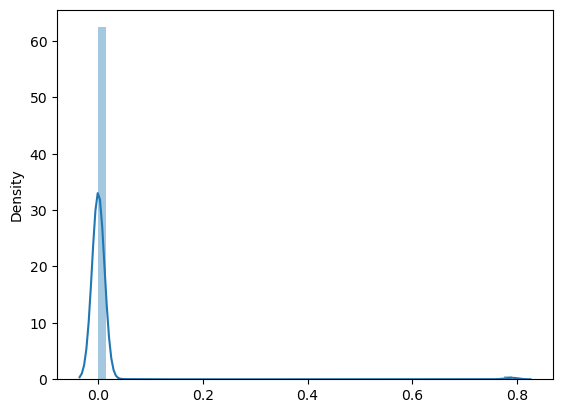

In [78]:
sns.distplot(y_train_pred_proba)

In [79]:
y_train_pred_proba.shape

(9944, 1, 1)

In [80]:
y_train.shape

(9944,)

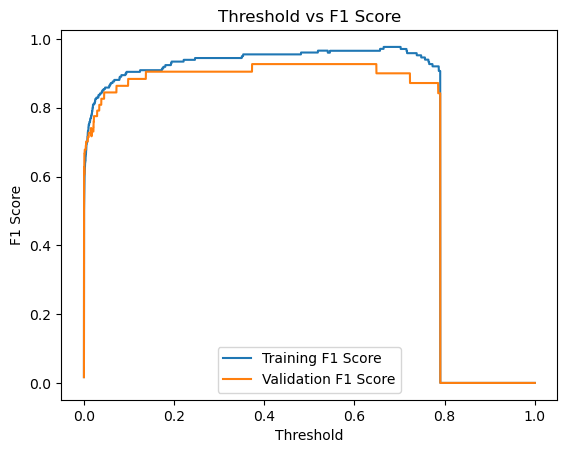

In [81]:
def f1_optimal_threshold(y_train_true, y_train_proba, y_val_true, y_val_proba):
    # Convert inputs to numpy arrays to ensure compatibility
    #y_train_true = np.array(y_train_true)
    #y_train_proba = np.array(y_train_proba)
    #y_val_true = np.array(y_val_true)
    #y_val_proba = np.array(y_val_proba)
    
    thresholds = np.linspace(0, 1, 20000)
    train_f1_scores = []
    val_f1_scores = []
    y_train_proba = np.squeeze(y_train_proba, axis=(1, 2)) 
    y_val_proba=np.squeeze(y_val_proba, axis=(1, 2)) 
    for threshold in thresholds:
        y_train_pred = np.where(y_train_proba > threshold, 1, 0)
        y_val_pred = np.where(y_val_proba > threshold, 1, 0)
        train_f1_scores.append(f1_score(y_train_true, y_train_pred))
        val_f1_scores.append(f1_score(y_val_true, y_val_pred))
    
    plt.plot(thresholds, train_f1_scores, label='Training F1 Score')
    plt.plot(thresholds, val_f1_scores, label='Validation F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Threshold vs F1 Score')
    plt.legend()
    plt.show()
    
    return thresholds, train_f1_scores, val_f1_scores

# Example usage:
# Ensure y_train, y_train_pred_proba, y_val, y_val_pred_proba are properly defined
thresholds, train_f1_scores, val_f1_scores = f1_optimal_threshold(y_train, y_train_pred_proba, 
                                                                  y_val, y_val_pred_proba)

In [82]:
optimal_index = np.argmax(train_f1_scores)
optimal_threshold = thresholds[optimal_index]
optimal_threshold

0.6645332266613331

In [83]:
y_train_pred_proba = np.squeeze(y_train_pred_proba, axis=(1, 2)) 
y_test_pred_proba = np.squeeze(y_test_pred_proba, axis=(1, 2)) 
y_train_bert_pred = np.where(y_train_pred_proba>optimal_threshold, 1, 0)
y_test_bert_pred = np.where(y_test_pred_proba>optimal_threshold, 1, 0)
y_val_pred_proba = np.squeeze(y_val_pred_proba, axis=(1, 2)) 
y_val_bert_pred = np.where(y_val_pred_proba>optimal_threshold, 1, 0)

In [84]:
print(classification_report(y_train, y_train_bert_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9859
           1       0.97      0.99      0.98        85

    accuracy                           1.00      9944
   macro avg       0.98      0.99      0.99      9944
weighted avg       1.00      1.00      1.00      9944



<Figure size 500x500 with 0 Axes>

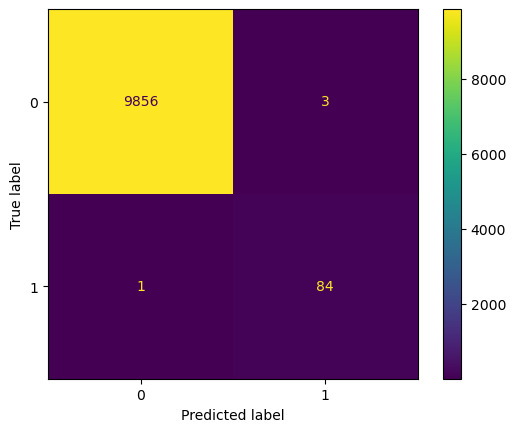

In [85]:
#Confusion matrix for training data

plt.figure(figsize=(5,5))
cm = confusion_matrix(y_train,y_train_bert_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [86]:
print(classification_report(y_val,y_val_bert_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2466
           1       0.95      0.86      0.90        21

    accuracy                           1.00      2487
   macro avg       0.97      0.93      0.95      2487
weighted avg       1.00      1.00      1.00      2487



<Figure size 500x500 with 0 Axes>

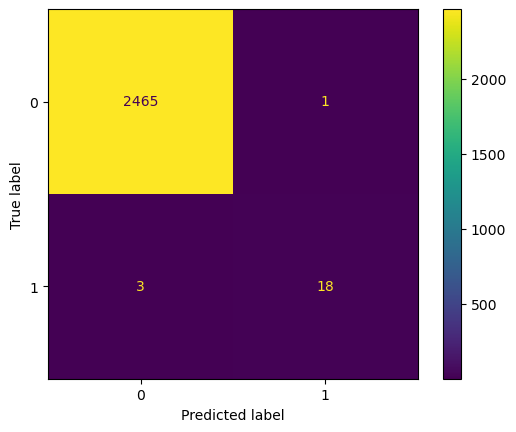

In [87]:
#Confusion matrix for val data

plt.figure(figsize=(5,5))
cm = confusion_matrix(y_val,y_val_bert_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [88]:
print(classification_report(y_test, y_test_bert_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3081
           1       0.96      0.89      0.92        27

    accuracy                           1.00      3108
   macro avg       0.98      0.94      0.96      3108
weighted avg       1.00      1.00      1.00      3108



<Figure size 500x500 with 0 Axes>

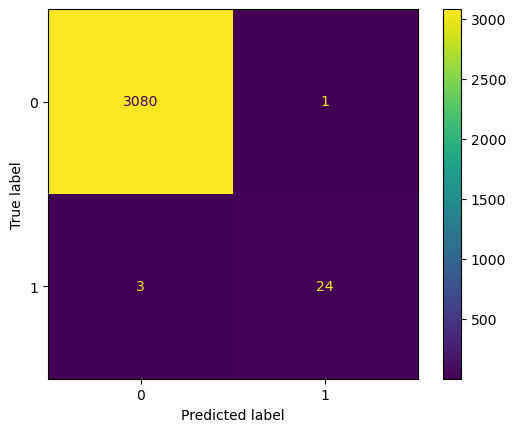

In [89]:
#Confusion matrix for test data

plt.figure(figsize=(5,5))
cm = confusion_matrix(y_test,y_test_bert_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [189]:
print(classification_report(y_test, y_test_bert_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3082
           1       0.92      0.88      0.90        26

    accuracy                           1.00      3108
   macro avg       0.96      0.94      0.95      3108
weighted avg       1.00      1.00      1.00      3108



<Figure size 500x500 with 0 Axes>

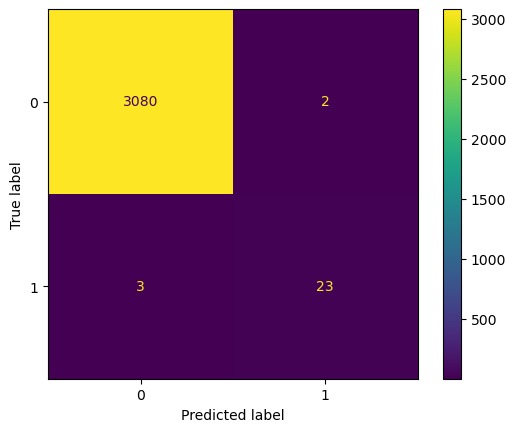

In [190]:
#Confusion matrix for test data

plt.figure(figsize=(5,5))
cm = confusion_matrix(y_test,y_test_bert_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()